In [3]:
import pandas as pd
import numpy as np
import os
import json

# Why not task A data?

In [9]:
taskA_path = '/Users/egesualp/Documents/lmu_repos/skills4cpp/data/talent_clef/TaskA/training'

# Import TaskA training data
taskA_df = pd.read_csv('/Users/egesualp/Documents/lmu_repos/skills4cpp/data/talent_clef/TaskA/training/english/taskA_training_en.tsv', 
                       sep='\t', header=None)



In [58]:
taskA_df.id.nunique()

3011

In [11]:
taskA_df.columns = ['family_id', 'id', 'jobtitle_1', 'jobtitle_2']

In [14]:
df_1 = taskA_df[['id', 'jobtitle_1']].drop_duplicates().rename(columns={'jobtitle_1': 'jobtitle'})
df_2 = taskA_df[['id', 'jobtitle_2']].drop_duplicates().rename(columns={'jobtitle_2': 'jobtitle'})

df_3 = pd.concat([df_1, df_2]).drop_duplicates()

In [15]:
df_3.head()

,id,jobtitle
0,http://data.europa.eu/esco/occupation/f2cc5978...,air commodore
1,http://data.europa.eu/esco/occupation/f2cc5978...,command and control officer
3,http://data.europa.eu/esco/occupation/f2cc5978...,pilot officer
4,http://data.europa.eu/esco/occupation/f2cc5978...,royal airforce officer
5,http://data.europa.eu/esco/occupation/f2cc5978...,squadron leader


In [16]:
esco_titles = pd.read_csv('../data/esco_datasets/occupations_en.csv')

In [17]:
esco_titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   conceptType              3039 non-null   object
 1   conceptUri               3039 non-null   object
 2   iscoGroup                3039 non-null   int64 
 3   preferredLabel           3039 non-null   object
 4   altLabels                3011 non-null   object
 5   hiddenLabels             8 non-null      object
 6   status                   3039 non-null   object
 7   modifiedDate             3039 non-null   object
 8   regulatedProfessionNote  3039 non-null   object
 9   scopeNote                307 non-null    object
 10  definition               8 non-null      object
 11  inScheme                 3039 non-null   object
 12  description              3039 non-null   object
 13  code                     3039 non-null   object
dtypes: int64(1), object(13)
memory usage: 33

In [19]:
esco_df = esco_titles[['conceptUri', 'preferredLabel', 'altLabels']]
esco_df.head()

,conceptUri,preferredLabel,altLabels
0,http://data.europa.eu/esco/occupation/00030d09...,technical director,technical and operations director\nhead of tec...
1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,metal drawing machine technician\nmetal drawin...
2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,inspector of precision instruments\nprecision ...
3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,air traffic safety electronics hardware specia...
4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,hospitality revenues manager\nyield manager\nh...


In [20]:
# Expand altLabels - create one row for each alternative label
expanded_rows = []

for _, row in esco_df.iterrows():
    concept_uri = row['conceptUri']
    preferred_label = row['preferredLabel']
    alt_labels = row['altLabels']
    
    # Add the preferred label as the first row
    expanded_rows.append({
        'conceptUri': concept_uri,
        'label': preferred_label,
        'label_type': 'preferred'
    })
    
    # Add each alternative label as separate rows
    if pd.notna(alt_labels) and alt_labels.strip():
        alt_label_list = alt_labels.split('\n')
        for alt_label in alt_label_list:
            alt_label = alt_label.strip()
            if alt_label:  # Only add non-empty labels
                expanded_rows.append({
                    'conceptUri': concept_uri,
                    'label': alt_label,
                    'label_type': 'alternative'
                })

# Create the expanded dataframe
esco_expanded = pd.DataFrame(expanded_rows)
print(f"Original esco_df shape: {esco_df.shape}")
print(f"Expanded esco_expanded shape: {esco_expanded.shape}")
esco_expanded.head(10)


Original esco_df shape: (3039, 3)
Expanded esco_expanded shape: (33412, 3)


,conceptUri,label,label_type
0,http://data.europa.eu/esco/occupation/00030d09...,technical director,preferred
1,http://data.europa.eu/esco/occupation/00030d09...,technical and operations director,alternative
2,http://data.europa.eu/esco/occupation/00030d09...,head of technical,alternative
3,http://data.europa.eu/esco/occupation/00030d09...,director of technical arts,alternative
4,http://data.europa.eu/esco/occupation/00030d09...,head of technical department,alternative
5,http://data.europa.eu/esco/occupation/00030d09...,technical supervisor,alternative
6,http://data.europa.eu/esco/occupation/00030d09...,technical manager,alternative
7,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,preferred
8,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine technician,alternative
9,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operative,alternative


In [23]:
esco_expanded.merge(df_3, how='left', left_on='label', right_on='jobtitle').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35322 entries, 0 to 35321
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   conceptUri  35322 non-null  object
 1   label       35322 non-null  object
 2   label_type  35322 non-null  object
 3   id          29228 non-null  object
 4   jobtitle    29228 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


In [63]:
esco_expanded.merge(
    df_3, 
    how='right', 
    left_on='label', 
    right_on='jobtitle'
    ).dropna().label.nunique()

26138

In [64]:
df_3.jobtitle.nunique()

26190

In [36]:
esco_expanded.query("label == 'driving instructor'").iloc[4,0]

'http://data.europa.eu/esco/occupation/c29f1a42-25cb-4192-9bc1-cc7560c00590'

In [34]:
df_3.query("jobtitle == 'driving instructor'")

,id,jobtitle
19604,http://data.europa.eu/esco/occupation/4666cccf...,driving instructor
19609,http://data.europa.eu/esco/occupation/834aab9b...,driving instructor
19624,http://data.europa.eu/esco/occupation/259d9967...,driving instructor


In [37]:
esco_titles.query('conceptUri == "http://data.europa.eu/esco/occupation/c29f1a42-25cb-4192-9bc1-cc7560c00590"')

,conceptType,conceptUri,iscoGroup,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,regulatedProfessionNote,scopeNote,definition,inScheme,description,code
2378,Occupation,http://data.europa.eu/esco/occupation/c29f1a42...,5165,truck driving instructor,lorry driver training instructor\ndriving inst...,NaN,released,2024-01-25T09:23:09.649Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Truck driving instructors teach people the the...,5165.1.4


In [38]:
df_3.query('jobtitle == "truck driving instructor"')

,id,jobtitle


In [43]:
esco_expanded.merge(
    df_3, 
    how='right', 
    left_on=['label', 'conceptUri'], 
    right_on=['jobtitle', 'id']
    ).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27079 entries, 0 to 27078
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   conceptUri  27027 non-null  object
 1   label       27027 non-null  object
 2   label_type  27027 non-null  object
 3   id          27079 non-null  object
 4   jobtitle    27079 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


In [44]:
esco_expanded.merge(
    df_3, 
    how='left', 
    left_on=['label', 'conceptUri'], 
    right_on=['jobtitle', 'id']
    ).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33412 entries, 0 to 33411
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   conceptUri  33412 non-null  object
 1   label       33412 non-null  object
 2   label_type  33412 non-null  object
 3   id          27027 non-null  object
 4   jobtitle    27027 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


In [56]:
esco_expanded.merge(
    df_3, 
    how='inner', 
    left_on=['label', 'conceptUri'], 
    right_on=['jobtitle', 'id']
    ).conceptUri.nunique()

3011

In [57]:
esco_expanded.merge(
    df_3, 
    how='inner', 
    left_on=['label', 'conceptUri'], 
    right_on=['jobtitle', 'id']
    ).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27027 entries, 0 to 27026
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   conceptUri  27027 non-null  object
 1   label       27027 non-null  object
 2   label_type  27027 non-null  object
 3   id          27027 non-null  object
 4   jobtitle    27027 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


In [48]:
esco_expanded.conceptUri.nunique()

3039

In [49]:
df_3.id.nunique()

3011

In [42]:
df_3.jobtitle.shape

(27003,)

In [51]:
esco_oldie = pd.read_csv(r"/Users/egesualp/Downloads/ESCO dataset - v1.1.2 - classification - en - csv/occupations_en.csv")

In [53]:
esco_oldie.merge(df_3, left_on='conceptUri', right_on='id', how='right').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conceptType              26776 non-null  object 
 1   conceptUri               26776 non-null  object 
 2   iscoGroup                26776 non-null  float64
 3   preferredLabel           26776 non-null  object 
 4   altLabels                26770 non-null  object 
 5   hiddenLabels             43 non-null     object 
 6   status                   26776 non-null  object 
 7   modifiedDate             26776 non-null  object 
 8   regulatedProfessionNote  26776 non-null  object 
 9   scopeNote                2697 non-null   object 
 10  definition               65 non-null     object 
 11  inScheme                 26776 non-null  object 
 12  description              26776 non-null  object 
 13  code                     26776 non-null  object 
 14  id                    

TalentCLEF in ESCO pool: 29228 items in ESCO pool (ESCO pool depth: 35322)
ESCO items in TalentCLEF: 29228 items of 29280 total items 

In [66]:
# task a evalutaion corpus

pd.read_csv(r"/Users/egesualp/Documents/lmu_repos/skills4cpp/data/talent_clef/TaskA/validation/english/corpus_elements", delimiter = "\t")

,c_id,jobtitle
0,1,recording engineer
1,2,director of taxation
2,3,technical support representative
3,4,hr manager
4,5,computer graphic artist
...,...,...
2614,2615,real estate broker
2615,2616,end user support specialist
2616,2617,implementation engineer
2617,2618,strategy and operations manager


In [67]:
esco_expanded.shape

(33412, 3)

In [68]:
df_3.shape

(27003, 2)

In [79]:
df = esco_expanded.merge(
    df_3, 
    left_on = ['conceptUri', 'label'], 
    right_on=['id', 'jobtitle'],
    how='left')

# Find non-match ratio per conceptUri
conceptUri_stats = df.groupby('conceptUri').agg({
    'jobtitle': lambda x: x.isna().sum() / len(x)  # ratio of non-matches per conceptUri
}).rename(columns={'jobtitle': 'non_match_ratio'})

# Non-match ratio overall
overall_non_match_ratio = df['jobtitle'].isna().sum() / len(df)
print(f"Overall non-match ratio: {overall_non_match_ratio:.4f}")

# Number of conceptUris which do not have any 'jobtitle' attached
conceptUris_without_jobtitle = df.groupby('conceptUri')['jobtitle'].apply(lambda x: x.isna().all()).sum()
print(f"Number of conceptUris without any jobtitle: {conceptUris_without_jobtitle}")

# Display conceptUri stats
print(f"Non-match ratio per conceptUri:")
print(conceptUri_stats.head(10))

Overall non-match ratio: 0.1911
Number of conceptUris without any jobtitle: 28
Non-match ratio per conceptUri:
                                                    non_match_ratio
conceptUri                                                         
http://data.europa.eu/esco/occupation/00030d09-...         0.000000
http://data.europa.eu/esco/occupation/000e93a3-...         0.083333
http://data.europa.eu/esco/occupation/0019b951-...         0.000000
http://data.europa.eu/esco/occupation/0022f466-...         0.000000
http://data.europa.eu/esco/occupation/002da35b-...         0.000000
http://data.europa.eu/esco/occupation/0044c991-...         0.111111
http://data.europa.eu/esco/occupation/00634fc4-...         0.285714
http://data.europa.eu/esco/occupation/00674f21-...         0.222222
http://data.europa.eu/esco/occupation/006cc1f9-...         0.461538
http://data.europa.eu/esco/occupation/00747307-...         0.100000


In [77]:
conceptUri_stats.merge(
    esco_titles[['conceptUri', 'preferredLabel']],
    how='left',
    on='conceptUri'
    ).sort_values(
        by="non_match_ratio", ascending=False).head(30)

,conceptUri,non_match_ratio,preferredLabel
1838,http://data.europa.eu/esco/occupation/95d0a616...,1.000000,family social worker
2642,http://data.europa.eu/esco/occupation/d9e4581a...,1.000000,footwear finishing and packing operator
1406,http://data.europa.eu/esco/occupation/71f09c8b...,1.000000,general practitioner
2664,http://data.europa.eu/esco/occupation/dc34c345...,1.000000,embalmer
252,http://data.europa.eu/esco/occupation/139fba7b...,1.000000,waste management supervisor
37,http://data.europa.eu/esco/occupation/026a5233...,1.000000,petroleum pump system operator
619,http://data.europa.eu/esco/occupation/30aef4c6...,1.000000,civil drafter
822,http://data.europa.eu/esco/occupation/41d4be58...,1.000000,derrickhand
2063,http://data.europa.eu/esco/occupation/a8ccc522...,1.000000,chemical tester
2887,http://data.europa.eu/esco/occupation/f31e25d0...,1.000000,leather goods maintenance technician


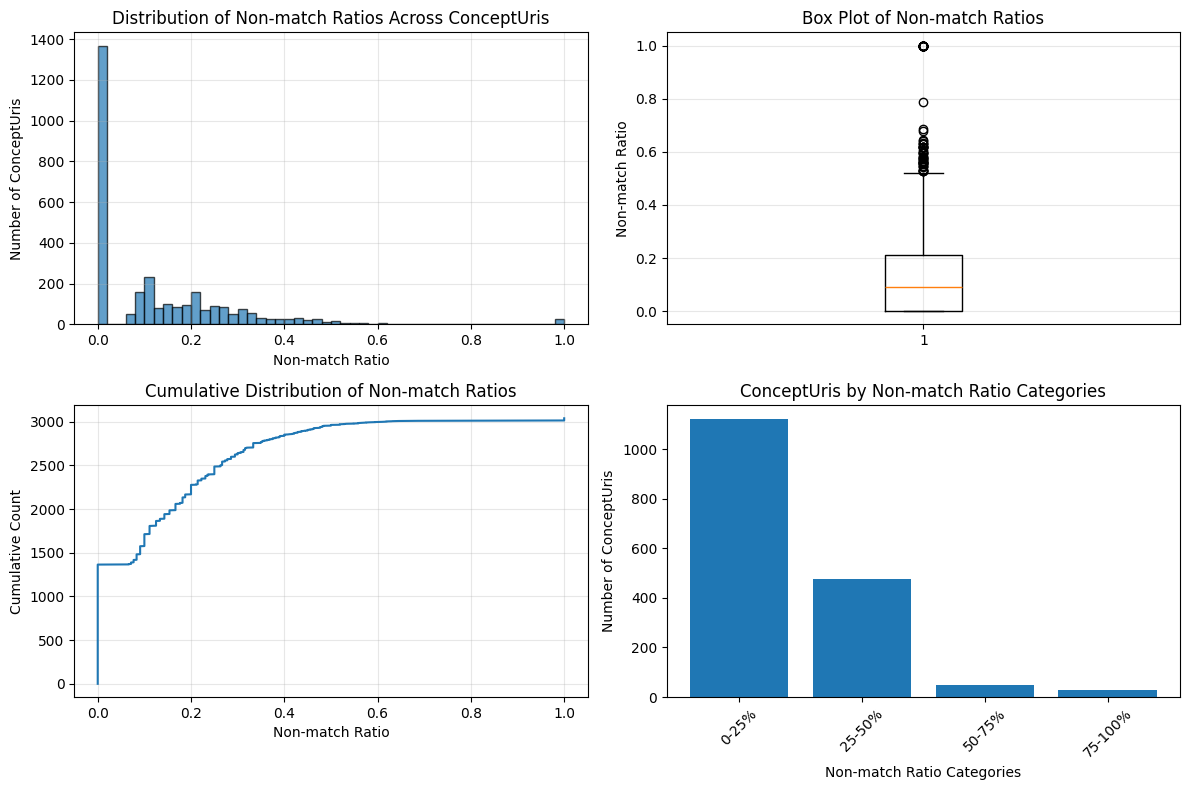


=== DESCRIPTIVE STATISTICS FOR NON-MATCH RATIOS ===
Total number of conceptUris: 3039
Mean non-match ratio: 0.1291
Median non-match ratio: 0.0909
Standard deviation: 0.1655
Minimum non-match ratio: 0.0000
Maximum non-match ratio: 1.0000

=== PERCENTILES ===
10th percentile: 0.0000
25th percentile: 0.0000
50th percentile: 0.0909
75th percentile: 0.2105
90th percentile: 0.3333
95th percentile: 0.4351
99th percentile: 0.6665

=== SEVERITY ANALYSIS ===
ConceptUris with perfect match (0% non-match): 1365 (44.9%)
ConceptUris with partial match (0-100% non-match): 1646 (54.2%)
ConceptUris with complete mismatch (100% non-match): 28 (0.9%)

=== TOP 10 WORST PERFORMING CONCEPTURIS ===
                               preferredLabel  non_match_ratio
1838                     family social worker              1.0
2642  footwear finishing and packing operator              1.0
1406                     general practitioner              1.0
2664                                 embalmer              1.0

In [80]:
# Visualize conceptUri stats
import matplotlib.pyplot as plt

# Create histogram of non-match ratios
plt.figure(figsize=(12, 8))

# Subplot 1: Histogram
plt.subplot(2, 2, 1)
plt.hist(conceptUri_stats['non_match_ratio'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Non-match Ratio')
plt.ylabel('Number of ConceptUris')
plt.title('Distribution of Non-match Ratios Across ConceptUris')
plt.grid(True, alpha=0.3)

# Subplot 2: Box plot
plt.subplot(2, 2, 2)
plt.boxplot(conceptUri_stats['non_match_ratio'])
plt.ylabel('Non-match Ratio')
plt.title('Box Plot of Non-match Ratios')
plt.grid(True, alpha=0.3)

# Subplot 3: Cumulative distribution
plt.subplot(2, 2, 3)
sorted_ratios = conceptUri_stats['non_match_ratio'].sort_values()
plt.plot(sorted_ratios.values, range(len(sorted_ratios)))
plt.xlabel('Non-match Ratio')
plt.ylabel('Cumulative Count')
plt.title('Cumulative Distribution of Non-match Ratios')
plt.grid(True, alpha=0.3)

# Subplot 4: Bar chart of ratio categories
plt.subplot(2, 2, 4)
ratio_categories = pd.cut(conceptUri_stats['non_match_ratio'], 
                         bins=[0, 0.25, 0.5, 0.75, 1.0], 
                         labels=['0-25%', '25-50%', '50-75%', '75-100%'])
ratio_counts = ratio_categories.value_counts()
plt.bar(ratio_counts.index, ratio_counts.values)
plt.xlabel('Non-match Ratio Categories')
plt.ylabel('Number of ConceptUris')
plt.title('ConceptUris by Non-match Ratio Categories')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Descriptive statistics
print("\n=== DESCRIPTIVE STATISTICS FOR NON-MATCH RATIOS ===")
print(f"Total number of conceptUris: {len(conceptUri_stats)}")
print(f"Mean non-match ratio: {conceptUri_stats['non_match_ratio'].mean():.4f}")
print(f"Median non-match ratio: {conceptUri_stats['non_match_ratio'].median():.4f}")
print(f"Standard deviation: {conceptUri_stats['non_match_ratio'].std():.4f}")
print(f"Minimum non-match ratio: {conceptUri_stats['non_match_ratio'].min():.4f}")
print(f"Maximum non-match ratio: {conceptUri_stats['non_match_ratio'].max():.4f}")

print(f"\n=== PERCENTILES ===")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = conceptUri_stats['non_match_ratio'].quantile(p/100)
    print(f"{p}th percentile: {value:.4f}")

print(f"\n=== SEVERITY ANALYSIS ===")
perfect_match = (conceptUri_stats['non_match_ratio'] == 0).sum()
complete_mismatch = (conceptUri_stats['non_match_ratio'] == 1).sum()
partial_match = ((conceptUri_stats['non_match_ratio'] > 0) & (conceptUri_stats['non_match_ratio'] < 1)).sum()

print(f"ConceptUris with perfect match (0% non-match): {perfect_match} ({perfect_match/len(conceptUri_stats)*100:.1f}%)")
print(f"ConceptUris with partial match (0-100% non-match): {partial_match} ({partial_match/len(conceptUri_stats)*100:.1f}%)")
print(f"ConceptUris with complete mismatch (100% non-match): {complete_mismatch} ({complete_mismatch/len(conceptUri_stats)*100:.1f}%)")

# Show worst performing conceptUris
print(f"\n=== TOP 10 WORST PERFORMING CONCEPTURIS ===")
worst_performers = conceptUri_stats.merge(
    esco_titles[['conceptUri', 'preferredLabel']],
    how='left',
    on='conceptUri'
).sort_values(by="non_match_ratio", ascending=False).head(10)
print(worst_performers[['preferredLabel', 'non_match_ratio']])

In [83]:
# Checking validation elements
taskA_val_corpus = pd.read_csv(
    '/Users/egesualp/Documents/lmu_repos/skills4cpp/data/talent_clef/TaskA/validation/english/corpus_elements',
    delimiter='\t')

In [86]:
taskA_val_corpus

,c_id,jobtitle
0,1,recording engineer
1,2,director of taxation
2,3,technical support representative
3,4,hr manager
4,5,computer graphic artist
...,...,...
2614,2615,real estate broker
2615,2616,end user support specialist
2616,2617,implementation engineer
2617,2618,strategy and operations manager


In [93]:
esco_expanded.merge(
    taskA_val_corpus,
    left_on = 'label',
    right_on='jobtitle',
    how='left'
).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33413 entries, 0 to 33412
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   conceptUri  33413 non-null  object 
 1   label       33413 non-null  object 
 2   label_type  33413 non-null  object 
 3   c_id        721 non-null    float64
 4   jobtitle    721 non-null    object 
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


In [89]:
taskA_qrels = pd.read_csv(
    r"/Users/egesualp/Documents/lmu_repos/skills4cpp/data/talent_clef/TaskA/validation/english/qrels.tsv",
    delimiter='\t',
    header=None
)

In [90]:
taskA_qrels

,0,1,2,3
0,1,0,143,1
1,1,0,150,1
2,1,0,764,1
3,1,0,870,1
4,1,0,1464,1
...,...,...,...,...
2415,105,0,2123,1
2416,105,0,2144,1
2417,105,0,2356,1
2418,105,0,2400,1


# Now this is for task B

In [2]:
# Read job2skill file
taskB_path = '/Users/egesualp/Documents/lmu_repos/skills4cpp/data/talent_clef/TaskB/training'

job2skill = pd.read_csv(os.path.join(taskB_path, 'job2skill.tsv'),
                        sep="\t",
                        names=["job_id","skill_id","rel_type"])
job2skill.head()

,job_id,skill_id,rel_type
0,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/93a68dcb-3dc6...,essential
1,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/05bc7677-5a64...,essential
2,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/860be36a-d19b...,essential
3,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/fed5b267-73fa...,essential
4,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/f64fe2c2-d090...,essential


In [3]:
with open(os.path.join(taskB_path,"jobid2terms.json"), 'r') as file:
    jobid2terms = json.load(file)

with open(os.path.join(taskB_path,"skillid2terms.json"), 'r') as file:
    skillid2terms = json.load(file)

In [4]:
job2skill["job_terms"] = job2skill["job_id"].map(jobid2terms)
job2skill["skill_terms"] = job2skill["skill_id"].map(skillid2terms)

In [5]:
job_id_to_search = job2skill.job_id.to_list()[8]
job_data = job2skill[job2skill.job_id == job_id_to_search]

In [6]:
job_data

,job_id,skill_id,rel_type,job_terms,skill_terms
0,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/93a68dcb-3dc6...,essential,"[technical director, technical and operations ...","[promote health and safety, promote importance..."
1,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/05bc7677-5a64...,essential,"[technical director, technical and operations ...","[organise rehearsals, organise rehearsal, orga..."
2,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/860be36a-d19b...,essential,"[technical director, technical and operations ...",[negotiate health and safety issues with third...
3,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/fed5b267-73fa...,essential,"[technical director, technical and operations ...","[theatre techniques, theatre technique, theatr..."
4,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/f64fe2c2-d090...,essential,"[technical director, technical and operations ...",[coordinate technical teams in artistic produc...
5,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/271a36a0-bc7a...,essential,"[technical director, technical and operations ...",[write risk assessment on performing arts prod...
6,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/591dd514-735b...,essential,"[technical director, technical and operations ...","[adapt to artists' creative demands, meet dema..."
7,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/47ed1d37-971b...,essential,"[technical director, technical and operations ...","[coordinate with creative departments, liaise ..."
8,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/892f8e2f-189a...,essential,"[technical director, technical and operations ...",[adapt designers’ work to the performance venu...
9,http://data.europa.eu/esco/occupation/00030d09...,http://data.europa.eu/esco/skill/a2dfc063-7b24...,optional,"[technical director, technical and operations ...","[write technical riders, collaborate for the c..."


In [9]:
len(skillid2terms.keys())

13939

In [10]:
len(jobid2terms.keys())

3039

In [11]:
esco = pd.read_csv(r'/Users/egesualp/Documents/lmu_repos/skills4cpp/data/processed/master_datasets/master_complete_hierarchy_w_occ.csv')

In [14]:
esco[~esco.level0_uri.isna()].skillUri.nunique()

13492

In [ ]:
    "http://data.europa.eu/esco/skill/00064735-8fad-454b-90c7-ed858cc993f2": [
        "supervise correctional procedures",
        "oversee prison procedures",
        "manage correctional procedures",
        "monitor correctional procedures",
        "manage prison procedures",
        "monitor prison procedures",
        "oversee correctional procedures"
    ],

In [20]:
esco.query('skillUri == "http://data.europa.eu/esco/skill/00064735-8fad-454b-90c7-ed858cc993f2"')[['skillLabel', 'skillAltLabels']].T

,86618
skillLabel,supervise correctional procedures
skillAltLabels,oversee prison procedures\nmanage correctional...


In [18]:
esco.columns

Index(['occupationUri', 'relationType', 'skillType_x', 'skillUri',
       'occupationLabel', 'iscoGroup', 'occupationDescription',
       'occupationCode', 'skillLabel', 'skillType_y', 'skillAltLabels',
       'reuseLevel', 'status', 'description', 'definition', 'level0_uri',
       'level0_label', 'level1_uri', 'level1_label', 'level2_uri',
       'level2_label', 'level3_uri', 'level3_label'],
      dtype='object')

In [ ]:
# Read job2skill file
taskB_path = '/Users/egesualp/Documents/lmu_repos/skills4cpp/data/talent_clef/TaskB/training'

job2skill = pd.read_csv(os.path.join(taskB_path, 'job2skill.tsv'),
                        sep="\t",
                        names=["job_id","skill_id","rel_type"])
job2skill.head()
with open(os.path.join(taskB_path,"jobid2terms.json"), 'r') as file:
    jobid2terms = json.load(file)

with open(os.path.join(taskB_path,"skillid2terms.json"), 'r') as file:
    skillid2terms = json.load(file)